## Import Modules

In [15]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import OneHotEncoder
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
# Set the dataset directory path
dataset_dir = './dataset/'

# Initialize lists to store file paths and corresponding labels
paths = []
labels = []

# Traverse through the dataset directory to gather .wav files and their labels
for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.wav'):
            # Full path to the .wav file
            full_path = os.path.join(root, file)
            paths.append(full_path)
            
            # Extracting the emotion label from the folder name (e.g., OAF_disgust)
            label = os.path.basename(root).split('_')[1].lower()
            labels.append(label)

print(f'Dataset loaded with {len(paths)} audio files.')


Dataset loaded with 5600 audio files.


In [5]:
# Create a DataFrame to organize the data
df = pd.DataFrame({
    'speech': paths,
    'label': labels
})

# Display the first few entries of the DataFrame
df.head()


,speech,label
0,./dataset/YAF_disgust/YAF_date_disgust.wav,disgust
1,./dataset/YAF_disgust/YAF_rag_disgust.wav,disgust
2,./dataset/YAF_disgust/YAF_raise_disgust.wav,disgust
3,./dataset/YAF_disgust/YAF_ditch_disgust.wav,disgust
4,./dataset/YAF_disgust/YAF_door_disgust.wav,disgust


## Checking for biases (Visually)

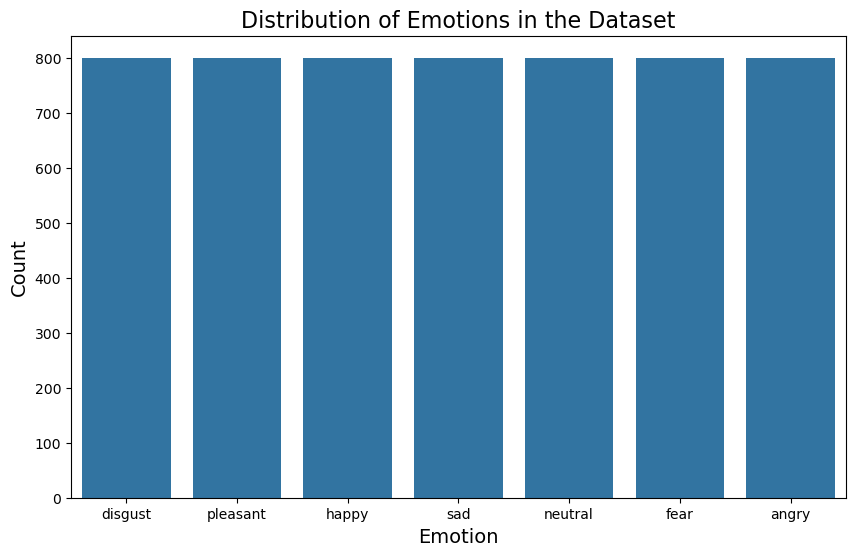

In [6]:
# Plot the distribution of emotions in the dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Emotions in the Dataset', fontsize=16)
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()


## Visualizing Waveforms & Spectrograms

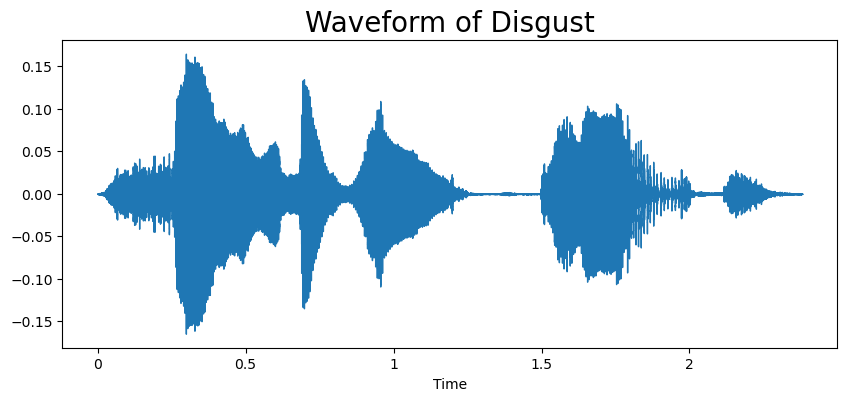

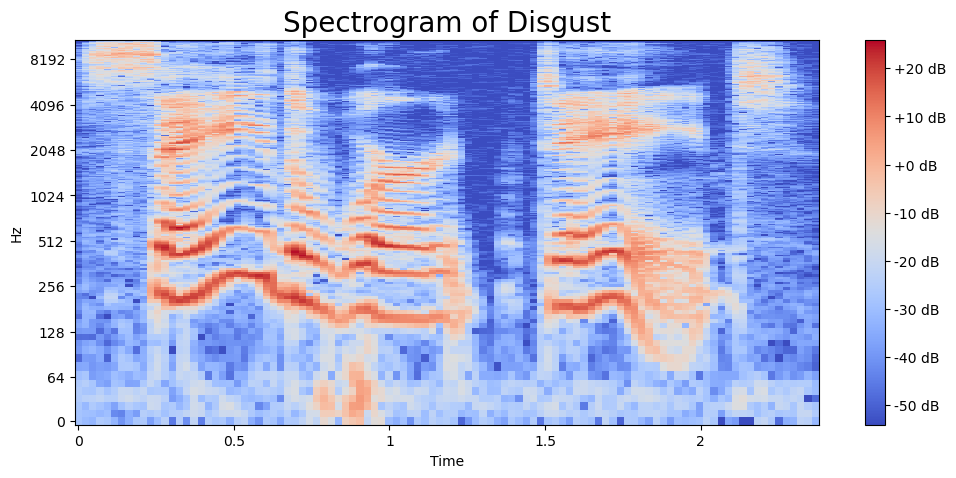

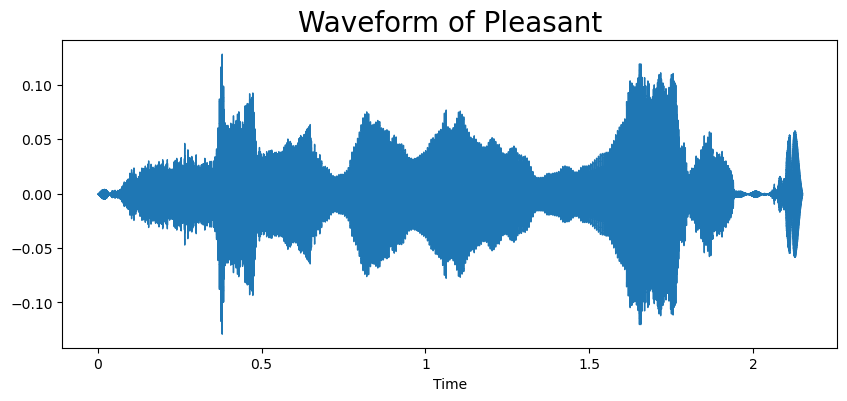

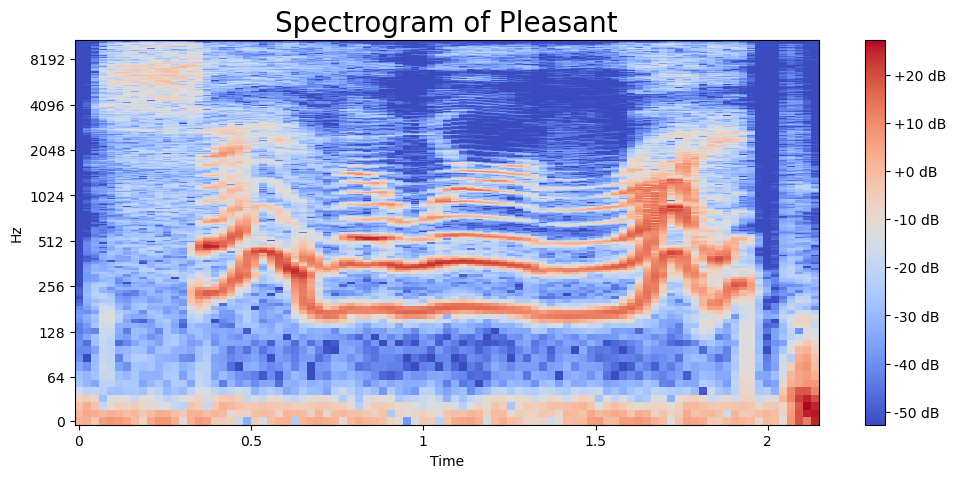

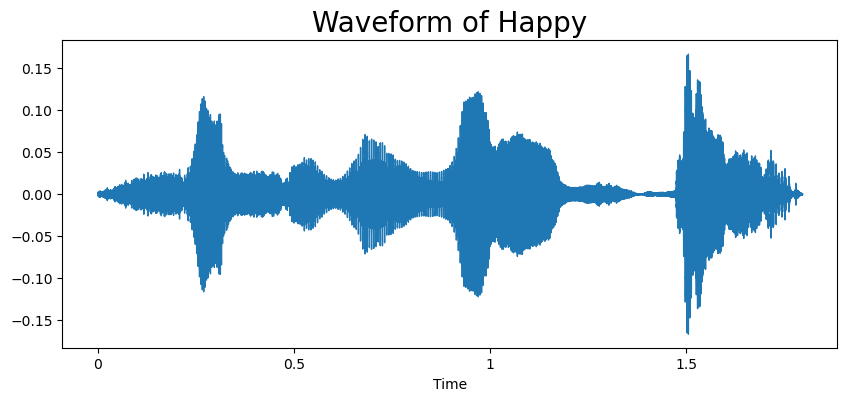

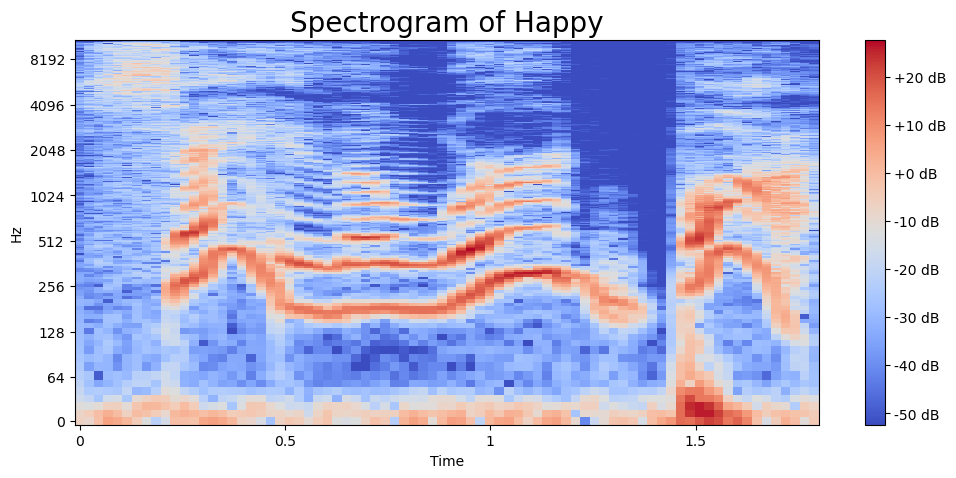

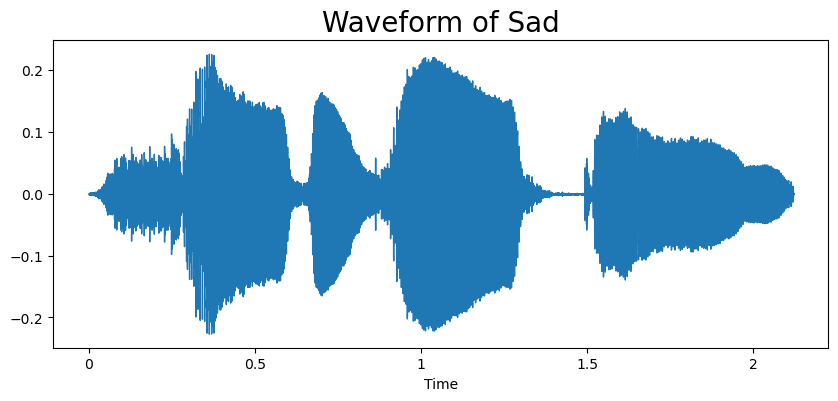

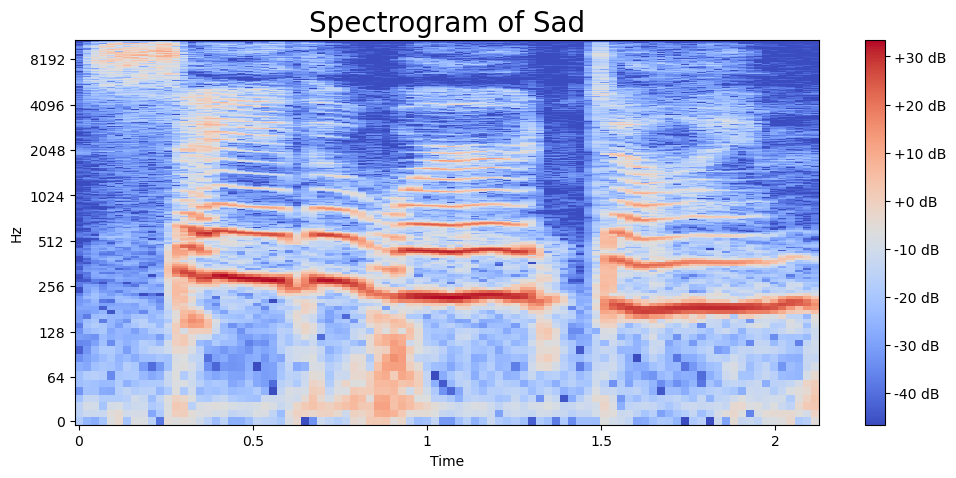

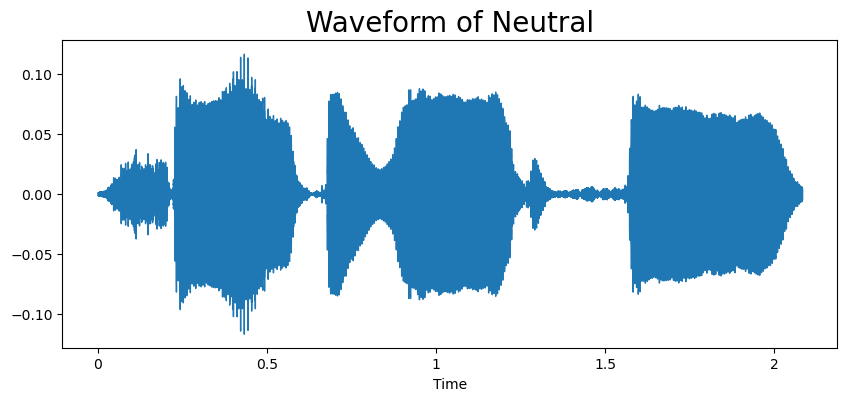

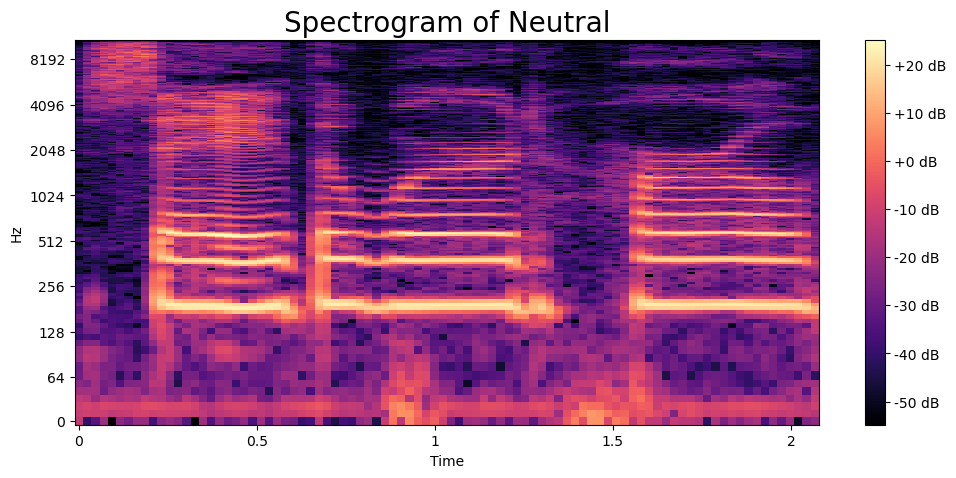

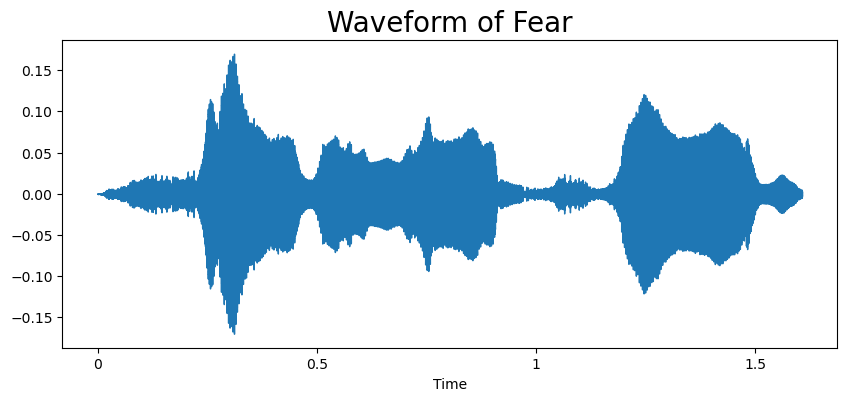

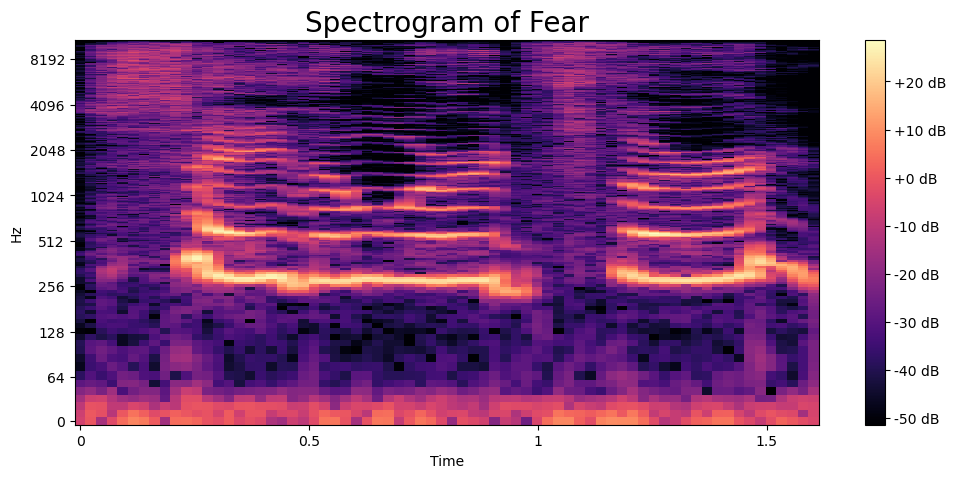

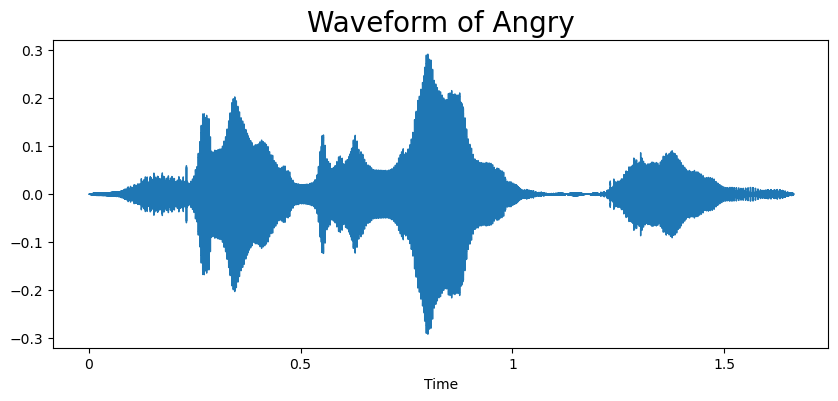

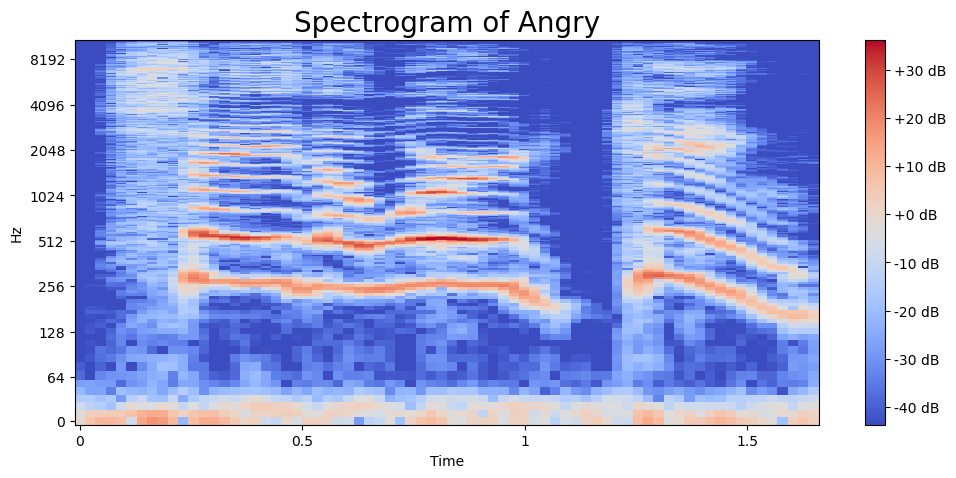

In [7]:
# Function to plot waveforms
def plot_waveform(data, sr, title):
    plt.figure(figsize=(10, 4))
    plt.title(f'Waveform of {title}', size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

# Function to plot spectrograms
def plot_spectrogram(data, sr, title):
    stft = librosa.stft(data)
    stft_db = librosa.amplitude_to_db(abs(stft))
    plt.figure(figsize=(12, 5))
    plt.title(f'Spectrogram of {title}', size=20)
    librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

# Select and visualize a few examples for different emotions
for emotion in df['label'].unique():
    sample_path = df[df['label'] == emotion]['speech'].iloc[0]
    data, sr = librosa.load(sample_path)
    
    # Plot waveform and spectrogram
    plot_waveform(data, sr, emotion.capitalize())
    plot_spectrogram(data, sr, emotion.capitalize())
    display(Audio(sample_path))


## Extracting MFCC features

In [8]:
# Function to extract MFCC features
def extract_features(file_path, n_mfcc=40):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Apply the MFCC extraction to all audio files
df['features'] = df['speech'].apply(extract_features)

# Convert features into a NumPy array for model training
X = np.array(df['features'].tolist())
X = np.expand_dims(X, axis=-1)


## One-Hot Encoding categorical features

In [17]:
# One-Hot Encoding of labels
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']]).toarray()

# Assuming X has the shape (n_samples, n_time_steps, n_features)
n_samples, n_time_steps, n_features = X.shape

# Reshape to (n_samples * n_time_steps, n_features)
X_reshaped = X.reshape(-1, n_features)

# Feature scaling
scaler = StandardScaler()
X_scaled_reshaped = scaler.fit_transform(X_reshaped)

# Reshape back to (n_samples, n_time_steps, n_features)
X_scaled = X_scaled_reshaped.reshape(n_samples, n_time_steps, n_features)


## Building Model Architecture

In [20]:
# LSTM model architecture
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(X.shape[1], 1)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

# Reshaping input data for LSTM
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], X_scaled.shape[1], 1))

# Setting up callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [21]:
# Training the model
history = model.fit(
    X_reshaped, y,
    validation_split=0.2,  
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1
)


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2753 - loss: 1.7376
Epoch 1: val_accuracy improved from -inf to 0.50893, saving model to best_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 147ms/step - accuracy: 0.2762 - loss: 1.7355 - val_accuracy: 0.5089 - val_loss: 1.0030
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6504 - loss: 0.8731
Epoch 2: val_accuracy improved from 0.50893 to 0.73482, saving model to best_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.6507 - loss: 0.8724 - val_accuracy: 0.7348 - val_loss: 0.6320
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7953 - loss: 0.5921
Epoch 3: val_accuracy improved from 0.73482 to 0.86875, saving model to best_model.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.7955 - loss: 0.5916 - val_accuracy: 0.8687 - val_loss: 0.3812
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8593 - loss: 0.4324
Epoch 4: val_accurac

## Visualizing learning Curve

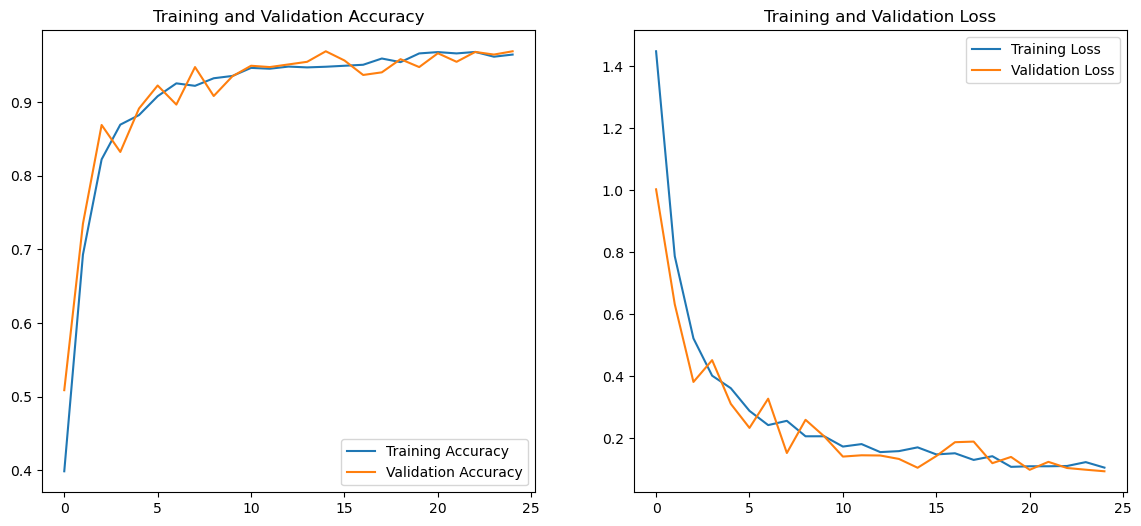

In [22]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()